<a href="https://colab.research.google.com/github/rvraghvender/DataScience/blob/master/Masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand segmentation in Images (Background removal)

In [35]:
import zipfile
import gdown
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
from glob import glob
from tqdm import tqdm
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


from albumentations import HorizontalFlip
from albumentations import GridDistortion
from albumentations import OpticalDistortion
from albumentations import ChannelShuffle
from albumentations import CoarseDropout
from albumentations import CenterCrop
from albumentations import Crop
from albumentations import Rotate


from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

from tensorflow.keras.utils import CustomObjectScope

import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
# %rm new_data -r
# %rm files -r

In [3]:
file_name = 'public_hand_dataset.zip'

if not os.path.isfile(file_name):
    file_id = '1Mc72BLGnZZQ0mhnh9rHOdJzYmITN-PPL'
    url = f'https://drive.google.com/uc?id={file_id}'

    downloaded_file = gdown.download(url, quiet=False)
    with zipfile.ZipFile(downloaded_file) as zf:
        zf.extractall()
else:
    print('File already exists.')

File already exists.


In [4]:
file_name_prefix = file_name.split('.')[0]
list_folder = os.listdir(file_name_prefix)
print(f'Number of examples in dataset: {len(list_folder)}')

Number of examples in dataset: 150


In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
def load_data(path, split=0.1):

    # Loading the original and mask images"
    X = sorted(glob(os.path.join(path, "*", "original", "*.jpeg")))
    Y = sorted(glob(os.path.join(path, "*", "no_bg", "*.jpeg")))

    # Splitting the data into training and testing
    split_size = int(len(X) * split)

    train_x, test_x = train_test_split(X, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(Y, test_size=split_size, random_state=42)

    return (train_x, train_y), (test_x, test_y)

In [7]:
np.random.seed(42)

# Load the dataset
data_path = "public_hand_dataset"
(train_x, train_y), (test_x, test_y) = load_data(data_path)
print(f"Train: \t{len(train_x)} - {len(train_y)}")
print(f"Test: \t{len(test_x)} - {len(test_y)}")


Train: 	135 - 135
Test: 	15 - 15


In [8]:
# Creating directories to save the augumented data
create_dir("new_data/train/original_images/")
create_dir("new_data/train/mask_images/")
create_dir("new_data/test/original_images/")
create_dir("new_data/test/mask_images/")

In [9]:
# Data augmentation
def augment_data(images, masks, save_path, augment=True):
    H = 512
    W = 256

    for x, y in tqdm(zip(images, masks), total=len(images)):
        # Extract the name
        original_image_name = x.split('/')
        original_image_name = '-'.join(original_image_name[1:])

        mask_image_name = y.split('/')
        mask_image_name = '-'.join(mask_image_name[1:])

        # Reading the image and mask
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            x2 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
            y2 = cv2.cvtColor(y, cv2.COLOR_RGB2GRAY)

            aug = ChannelShuffle(p=1)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = CoarseDropout(p=1, min_holes=3, max_holes=10, max_height=32, max_width=32)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            X = [x, x1, x2, x3, x4, x5]
            Y = [y, y1, y2, y3, y4, y5]
        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):

            try:
                import tttttttttt
                # Center cropping
                aug = CenterCrop(H, W, p=1.0)
                augmented = aug(image=i, mask=m)
                i = augmented['image']
                m = augmented['mask']

            except Exception as e:
                i = cv2.resize(i, (W, H))
                m = cv2.resize(m, (W, H))

            image_path = os.path.join(save_path, "original_images", f"{index}_{original_image_name}")
            mask_path = os.path.join(save_path, "mask_images", f"{index}_{mask_image_name}")

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

In [10]:
augment_data(train_x, train_y, "new_data/train/", augment=True)
augment_data(test_x, test_y, "new_data/test/", augment=False)

100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


In [11]:
def squeeze_and_excite(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = init * se
    return x



In [12]:
def ASPP(inputs):
    " Image Pooling"
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding='same', use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    " 1X1 Conv "
    y2 = Conv2D(256, 1, padding='same', use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)

    " 3X3 Conv rate=6 "
    y3 = Conv2D(256, 3, padding='same', use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation('relu')(y3)

    " 3X3 Conv rate=12 "
    y4 = Conv2D(256, 3, padding='same', use_bias=False, dilation_rate=12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation('relu')(y4)

    " 3X3 Conv rate=18 "
    y5 = Conv2D(256, 3, padding='same', use_bias=False, dilation_rate=18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation('relu')(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    " 1X1 Conv "
    y = Conv2D(256, 1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    return y

In [13]:
def deeplabv3_plus(shape):

    # Input
    inputs = Input(shape)

    # Encoder
    encoder = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    image_features = encoder.get_layer("conv4_block5_out").output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4,4), interpolation='bilinear')(x_a)

    x_b = encoder.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = squeeze_and_excite(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = squeeze_and_excite(x)

    x = UpSampling2D((4,4), interpolation='bilinear')(x)
    x = Conv2D(1,1)(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs, x)
    return model




In [14]:
model = deeplabv3_plus((512,256, 3))
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [15]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true , y_pred)

In [16]:
H = 512
W = 256
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

In [18]:
create_dir("files")

In [19]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.
    x = x.astype(np.float32)
    return x

In [20]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x / 255.
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [21]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [22]:
def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [23]:
# Hyperparameters
batch_size = 2
lr = 1e-4
num_epochs = 20
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")

dataset_path = 'new_data'
train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'test')

train_x = sorted(glob(os.path.join(train_path, 'original_images', '*jpeg')))
train_y = sorted(glob(os.path.join(train_path, 'mask_images', '*jpeg' )))

train_x, train_y = shuffling(train_x, train_y)

valid_x = sorted(glob(os.path.join(valid_path, 'original_images', '*jpeg' )))
valid_y = sorted(glob(os.path.join(valid_path,  'mask_images', '*jpeg' )))

print(f"Train: \t{len(train_x)} - {len(train_y)}")
print(f"Test: \t{len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

# Model
model  = deeplabv3_plus((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])


# Saving checkpoint
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Train: 	810 - 810
Test: 	15 - 15
Epoch 1/20
405/405 [==============================] - ETA: 0s - loss: 0.3880 - dice_coef: 0.6120 - iou: 0.4479 - recall: 0.7926 - precision: 0.9086
Epoch 1: val_loss improved from inf to 0.68453, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


405/405 [==============================] - 98s 127ms/step - loss: 0.3880 - dice_coef: 0.6120 - iou: 0.4479 - recall: 0.7926 - precision: 0.9086 - val_loss: 0.6845 - val_dice_coef: 0.3125 - val_iou: 0.1857 - val_recall: 0.4735 - val_precision: 0.6311 - lr: 1.0000e-04
Epoch 2/20
405/405 [==============================] - ETA: 0s - loss: 0.3212 - dice_coef: 0.6788 - iou: 0.5170 - recall: 0.7871 - precision: 0.9931
Epoch 2: val_loss improved from 0.68453 to 0.56600, saving model to files/model.h5
405/405 [==============================] - 50s 124ms/step - loss: 0.3212 - dice_coef: 0.6788 - iou: 0.5170 - recall: 0.7871 - precision: 0.9931 - val_loss: 0.5660 - val_dice_coef: 0.4255 - val_iou: 0.2758 - val_recall: 0.2996 - val_precision: 0.9811 - lr: 1.0000e-04
Epoch 3/20
405/405 [==============================] - ETA: 0s - loss: 0.3108 - dice_coef: 0.6892 - iou: 0.5290 - recall: 0.7911 - precision: 0.9966
Epoch 3: val_loss improved from 0.56600 to 0.35992, saving model to files/model.h5
405/

In [24]:
 np.random.seed(42)
 tf.random.set_seed(42)

 # Directory for storing files
 create_dir('results')

 # Load the model
 with CustomObjectScope({'iou' : iou, 'dice_coef' : dice_coef, 'dice_loss' : dice_loss}):
    model = tf.keras.models.load_model('files/model.h5')
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [25]:
# Load the test dataset
dataset_path = 'new_data'
test_x = sorted(glob(os.path.join(dataset_path, 'test', 'original_images', '*jpeg')))
test_y = sorted(glob(os.path.join(dataset_path, 'test', 'mask_images', '*jpeg')))
print(f'Test: \t{len(test_x)} - {len(test_y)}')

Test: 	15 - 15


In [33]:
def save_results(image, mask, y_pred, save_image_path):
    ## i - m - yp - yp*i
    line = np.ones((H, 10, 3)) * 128

    mask = np.expand_dims(mask, axis=-1) # (512, 256, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1) # (512, 256, 3)
    mask = mask * 255.

    y_pred = np.expand_dims(y_pred, axis=-1) # (512, 256, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) # (512, 256, 3)
    # y_pred = y_pred * 255.

    masked_image = image * y_pred
    y_pred = y_pred * 255.

    cat_images = np.concatenate([image, line, mask, line, y_pred, line, masked_image], axis=1)
    cv2.imwrite(save_image_path, cat_images)




In [44]:
# Evaluation and Prediction
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):

    # Extract the name
    name = x.split('/')
    name = '-'.join(name[3:])

    # Reading the image
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    x = image/ 255.0
    x = np.expand_dims(x, axis=0)

    # Reading the mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    # mask = mask/255.0

    # Prediction
    y_pred = model.predict(x)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)

    # Saving the prediction
    save_image_path = f'results/{name}'
    save_results(image, mask, y_pred, save_image_path)

    # Flatten the array
    mask = mask.flatten()
    y_pred = y_pred.flatten()

    mask = [1 if k>= 1 else k for k in mask]

    # Calculating the metrics values
    acc_value = accuracy_score(mask, y_pred)
    f1_value = f1_score(mask, y_pred, labels=[0,1], average='binary')
    jaccard_value = jaccard_score(mask, y_pred, labels=[0,1], average='binary')
    recall_value = recall_score(mask, y_pred, labels=[0,1], average='binary')
    precision_value = precision_score(mask, y_pred, labels=[0,1], average='binary')
    SCORE.append([name, acc_value, f1_value, jaccard_value, recall_value, precision_value])


# Metrics values
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f'Accuracy : \t {score[0]:0.5f}')
print(f'F1 : \t {score[1]:0.5f}')
print(f'Jaccard : \t {score[2]:0.5f}')
print(f'Recall : \t {score[3]:0.5f}')
print(f'Precision : \t {score[4]:0.5f}')

df = pd.DataFrame(SCORE, columns=['Image', 'Accuracy', 'F1', 'Jaccard', 'Recall', 'Precision'])
df.to_csv('files/score.csv')

  0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 1/15 [00:00<00:10,  1.39it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 2/15 [00:01<00:09,  1.43it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 3/15 [00:02<00:08,  1.42it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 4/15 [00:02<00:07,  1.44it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 5/15 [00:03<00:06,  1.45it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 6/15 [00:04<00:06,  1.45it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 7/15 [00:04<00:05,  1.46it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 8/15 [00:05<00:04,  1.45it/s]

1/1 [==============================] - 0s 63ms/step


 60%|██████    | 9/15 [00:06<00:04,  1.45it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 10/15 [00:06<00:03,  1.44it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 11/15 [00:07<00:02,  1.44it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 12/15 [00:08<00:02,  1.44it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 13/15 [00:09<00:01,  1.26it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 14/15 [00:10<00:00,  1.11it/s]

1/1 [==============================] - 0s 60ms/step


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]

Accuracy : 	 0.93232
F1 : 	 0.81829
Jaccard : 	 0.71990
Recall : 	 0.72895
Precision : 	 0.96622


In [4]:
original_image_list = []
mask_image_list = []

for pathh in list_folder:

    original_image_path = os.path.join(file_name_prefix, pathh, 'original')
    mask_image_path = os.path.join(file_name_prefix, pathh, 'no_bg')

    original_image_list.append( os.path.join(original_image_path, os.listdir(original_image_path)[0]) )
    mask_image_list.append( os.path.join(mask_image_path, os.listdir(mask_image_path)[0]) )

Text(0.5, 1.0, 'Masked hand')

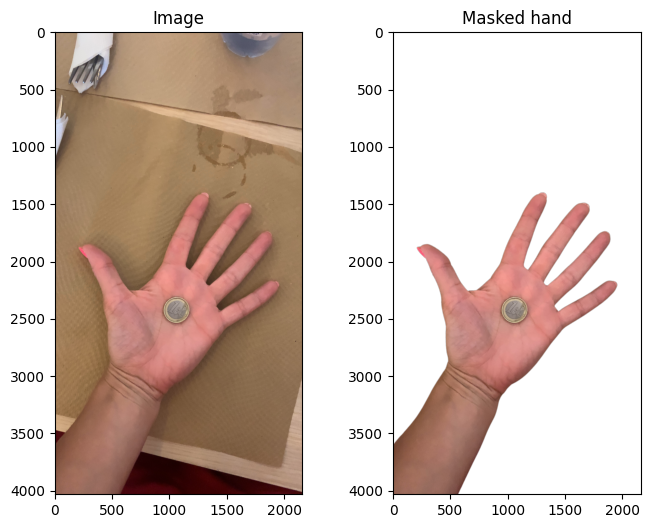

In [5]:
N = 3
img = imageio.imread(original_image_list[N])
mask = imageio.imread(mask_image_list[N])

fig, arr = plt.subplots(1, 2, figsize=(8, 6))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, :])
arr[1].set_title('Masked hand')

In [6]:
image_list_ds = tf.data.Dataset.list_files(original_image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_image_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'public_hand_dataset/100328385179725049535622994313026736131/original/hand.jpeg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'public_hand_dataset/100328385179725049535622994313026736131/no_bg/hand.jpeg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'public_hand_dataset/101246170554525927110592012192635617282/original/hand.jpeg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'public_hand_dataset/101246170554525927110592012192635617282/no_bg/hand.jpeg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'public_hand_dataset/102586421877817102033289037136558555138/original/hand.jpeg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'public_hand_dataset/102586421877817102033289037136558555138/no_bg/hand.jpeg'>)


In [7]:
image_filename = tf.constant(original_image_list)
masks_filename = tf.constant(mask_image_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filename, masks_filename))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'public_hand_dataset/206013608894703933084483430189035618308/original/hand.jpeg', shape=(), dtype=string)
tf.Tensor(b'public_hand_dataset/206013608894703933084483430189035618308/no_bg/hand.jpeg', shape=(), dtype=string)


In [8]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    # input_image = input_image / 255.
    # input_mask = input_mask / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [9]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of
                       the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters,                 # Number of filters
                  3,                         # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)

    conv = Conv2D(n_filters,                 # Number of filters
                  3,                         # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'HeNormal')(conv)

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        # next_layer = MaxPooling2D(2, strides=2)(conv)
        next_layer = MaxPooling2D((2,2))(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [10]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    up = Conv2DTranspose(
                 n_filters,               # number of filters
                 3,                       # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)

    conv = Conv2D(n_filters,              # Number of filters
                  3,                      # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'HeNormal')(merge)
    conv = Conv2D(n_filters,              # Number of filters
                  3,                      # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'HeNormal')(conv)

    return conv

In [11]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)

    ####################################################################
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)

    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)

    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8, dropout_prob=0.3)

    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16, dropout_prob=0.3, max_pooling=False)

    ####################################################################
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)

    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer.
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='HeNormal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [12]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels), n_classes=1)

In [13]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [22]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
def display(display_list):
    plt.figure(figsize=(8, 8))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(4032, 2160, 1)


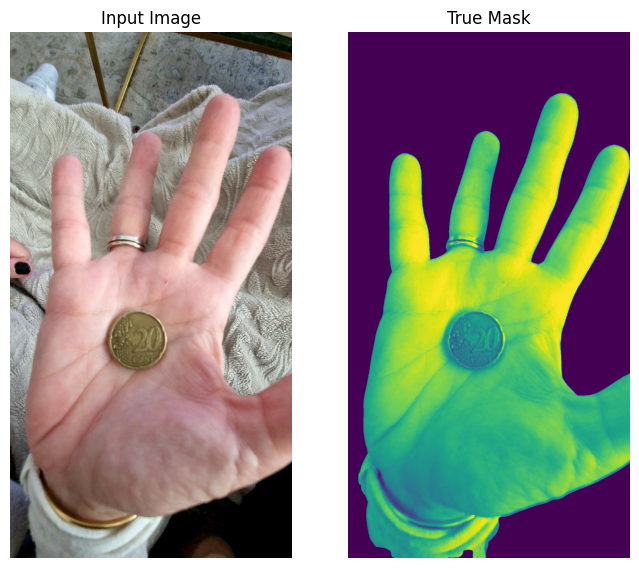

In [16]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


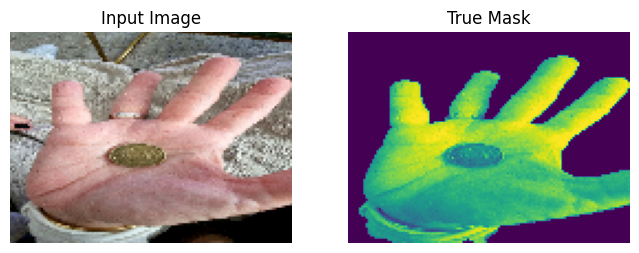

In [17]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [23]:
EPOCHS = 40
BUFFER_SIZE = 500
BATCH_SIZE = 1

processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40


InvalidArgumentError: ignored